<a href="https://colab.research.google.com/github/larasauser/2024_MLEES/blob/main/Project/project_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**# Machine learning Project - Sauser Lara**
## *Filling gaps in NDVI images using CNN and Diffusion models*

[Ajouter une image d'illustration]

##Main steps :


1.   Gather dataset
2.   Split the dataset
3.   Create the CNN alorithm
4.   Create the Dissolution model
5.   Evaluate them (RMSE ?)



### 1. Loading the data and separate them into smaller images (32x32 px)
--- This should be done only once per image set because it takes time ---

--- New image set should be used after this step ---



In [38]:
#Dataset stored on Google Drive
from google.colab import drive
drive.mount('/content/drive')


import os
folder_path = '/content/drive/My Drive/NDVI_Landsat8_10/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's visualise some of our original images.

RasterioIOError: /content/drive/My Drive/NDVI_Landsat8_10_/train/NDVI_2013-11-12.tif: No such file or directory

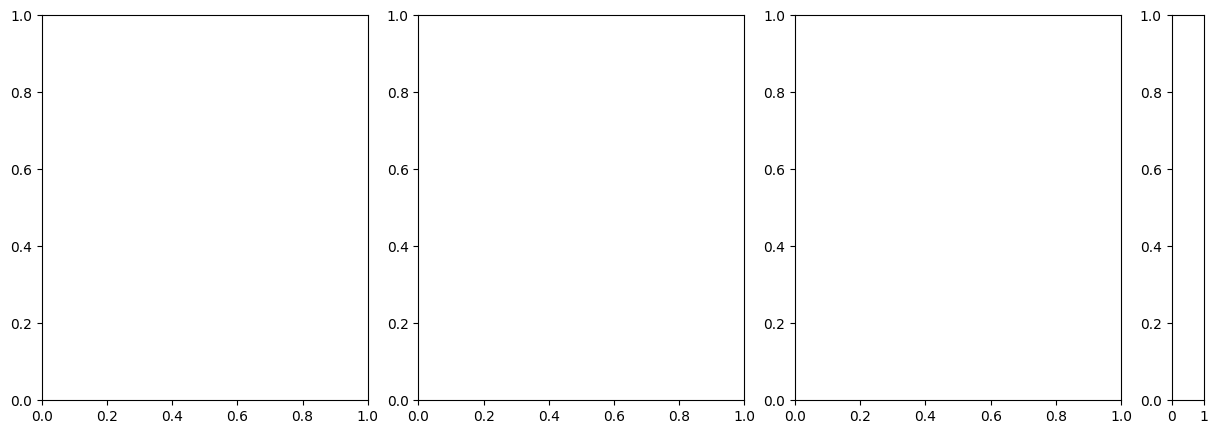

In [40]:
import rasterio
# Get a list of files in the directory
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [0, 5, 50 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

To have more images and to reduce computational cost, we decide to devide them into sub-images of 32x32 pixels.

In [ ]:
#pip install Pillow

In [4]:
from PIL import Image
img=Image.open('/content/drive/My Drive/NDVI_Landsat8_10/NDVI_2023-11-08.tif')
img_width, img_height = img.size
print(img_width)
print(img_height)


324
262


Ajouter de l'overlap ??

In [5]:
from PIL import Image
import os
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [6]:
#Split our images
output_folder = '/content/drive/My Drive/NDVI_Landsat8_10_/split'
process_all_images(folder_path, output_folder)

Image in treatment : NDVI_2013-04-18.tif
99
Image in treatment : NDVI_2013-11-12.tif
99
Image in treatment : NDVI_2013-11-28.tif
99
Image in treatment : NDVI_2013-12-30.tif
99
Image in treatment : NDVI_2014-03-20.tif
99
Image in treatment : NDVI_2014-10-30.tif
99
Image in treatment : NDVI_2014-06-08.tif
99
Image in treatment : NDVI_2015-02-19.tif
99
Image in treatment : NDVI_2015-04-08.tif
99
Image in treatment : NDVI_2015-04-24.tif
99
Image in treatment : NDVI_2015-05-10.tif
99
Image in treatment : NDVI_2015-08-30.tif
99
Image in treatment : NDVI_2015-12-20.tif
99
Image in treatment : NDVI_2016-04-10.tif
99
Image in treatment : NDVI_2016-10-03.tif
99
Image in treatment : NDVI_2016-12-06.tif
99
Image in treatment : NDVI_2017-03-28.tif
99
Image in treatment : NDVI_2017-01-23.tif
99
Image in treatment : NDVI_2017-04-29.tif
99
Image in treatment : NDVI_2017-04-13.tif
99
Image in treatment : NDVI_2018-06-19.tif
99
Image in treatment : NDVI_2018-10-09.tif
99
Image in treatment : NDVI_2018-1

Images are now splitted. We now have 13'365 images to use for our model.

### 2. Convolutional Neural Network (CNN)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#drive.flush_and_unmount('/content/drive')

Drive not mounted, so nothing to flush and unmount.


#### 2.0 Data Augmentation ???

#### 2.1 Split the dataset into train, test and validation set

In [8]:
import os
import random
import shutil

In [10]:
# Define the source directory and the new directories for train, validation, and test sets
source_dir = '/content/drive/My Drive/NDVI_Landsat8_10_/split'
train_dir = '/content/drive/My Drive/NDVI_Landsat8_10_/train'
val_dir = '/content/drive/My Drive/NDVI_Landsat8_10_/validation'
test_dir = '/content/drive/My Drive/NDVI_Landsat8_10_/test'

In [11]:
# Create the new directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [12]:
# Get all image files from the source directory
all_images = [f for f in os.listdir(source_dir) if f.endswith(('.tif'))]

In [13]:
# Shuffle the list of images
random.shuffle(all_images)

In [14]:
len(all_images)

13365

In [15]:
# Calculate the number of images for each set
total_images = len(all_images)
train_split = int(0.7 * total_images)
val_split = int(0.2 * total_images)

In [16]:
# Split the images into train, validation, and test sets
train_images = all_images[:train_split]
val_images = all_images[train_split:train_split+val_split]
test_images = all_images[train_split+val_split:]

In [17]:
# Function to copy images to their respective directories
def copy_images(image_list, destination):
    for image in image_list:
        src = os.path.join(source_dir, image)
        dst = os.path.join(destination, image)
        shutil.copy(src, dst)  # Use shutil.copy instead of shutil.move


In [18]:
# Copy the images to their respective directories
copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

In [19]:
print(f"Total images: {total_images}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Total images: 13365
Training images: 9355
Validation images: 2673
Test images: 1337


#### 2.2 Create fake holes in images for training

In [24]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [20]:
# Define the paths
train_dir = '/content/drive/My Drive/NDVI_Landsat8_10_/train'
output_dir = os.path.join(train_dir, 'train_with_holes')

In [21]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

I start with a simple hole : a rectangle

In [22]:
def add_fake_holes(image, num_holes=3, max_hole_size=8):
    """
    Add fake holes to an image to simulate cloud coverage.

    Args:
        image (numpy array): Input image as a NumPy array.
        num_holes (int): Number of fake holes to add.
        max_hole_size (int): Maximum size (in pixels) of each hole.

    Returns:
        numpy array: Image with fake holes applied.
    """
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = 0  # Simulate cloud (masked area)

    return image_with_holes


In [25]:
# Iterate over all images in the train_dir
for filename in os.listdir(train_dir):
    if filename.endswith(('.tif')):  # Add other formats if needed
        input_path = os.path.join(train_dir, filename)
        output_path = os.path.join(output_dir, filename)  # Save with the same name

        # Load the image
        image = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)  # Load in original format
        if image is None:
            print(f"Failed to load {filename}. Skipping...")
            continue

        # Add fake holes
        image_with_holes = add_fake_holes(image)

        # Save the new image in the output directory
        cv2.imwrite(output_path, image_with_holes)
        #print(f"Processed and saved: {output_path}")

print("All images processed successfully!")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Processed and saved: /content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes/NDVI_2017-04-20_sub_image_89.tif
Processed and saved: /content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes/NDVI_2014-11-22_sub_image_29.tif
Failed to load NDVI_2018-10-25_sub_image_11.tif. Skipping...
Processed and saved: /content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes/NDVI_2014-07-17_sub_image_18.tif
Processed and saved: /content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes/NDVI_2018-03-22_sub_image_20.tif
Processed and saved: /content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes/NDVI_2014-10-30_sub_image_55.tif
Processed and saved: /content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes/NDVI_2022-03-26_sub_image_42.tif
Processed and saved: /content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes/NDVI_2016-08-23_sub_image_21.tif
Processed and saved: /conten

Now that our training images are prepared, we can start building the CNN.

#### 2.3 Building the CNN

In [32]:
#Load the training data
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/My Drive/NDVI_Landsat8_10_/train'
train_with_holes_dir = '/content/drive/My Drive/NDVI_Landsat8_10_/train/train_with_holes'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import rasterio
import os
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PIL import Image

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


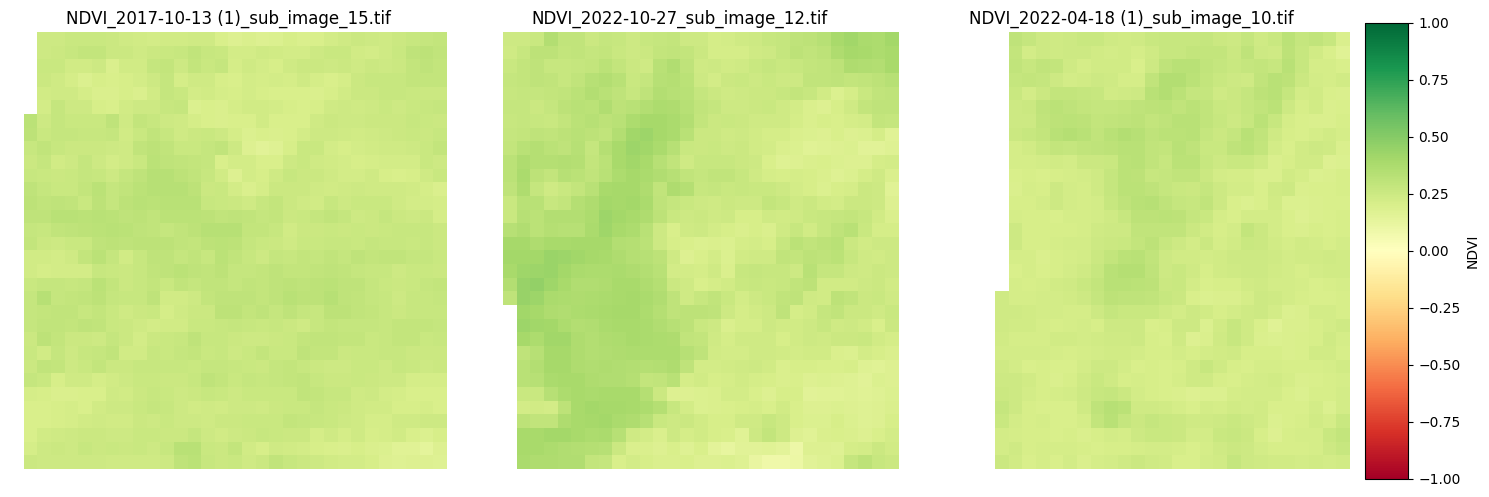

In [35]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_dir) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [0, 5, 500 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
# Get a list of all files in the directory
file_list = os.listdir(train_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 13365 files in the directory.


In [33]:
# Get a list of all files in the directory
file_list = os.listdir(train_with_holes_dir)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"There are {num_files} files in the directory.")

There are 8957 files in the directory.


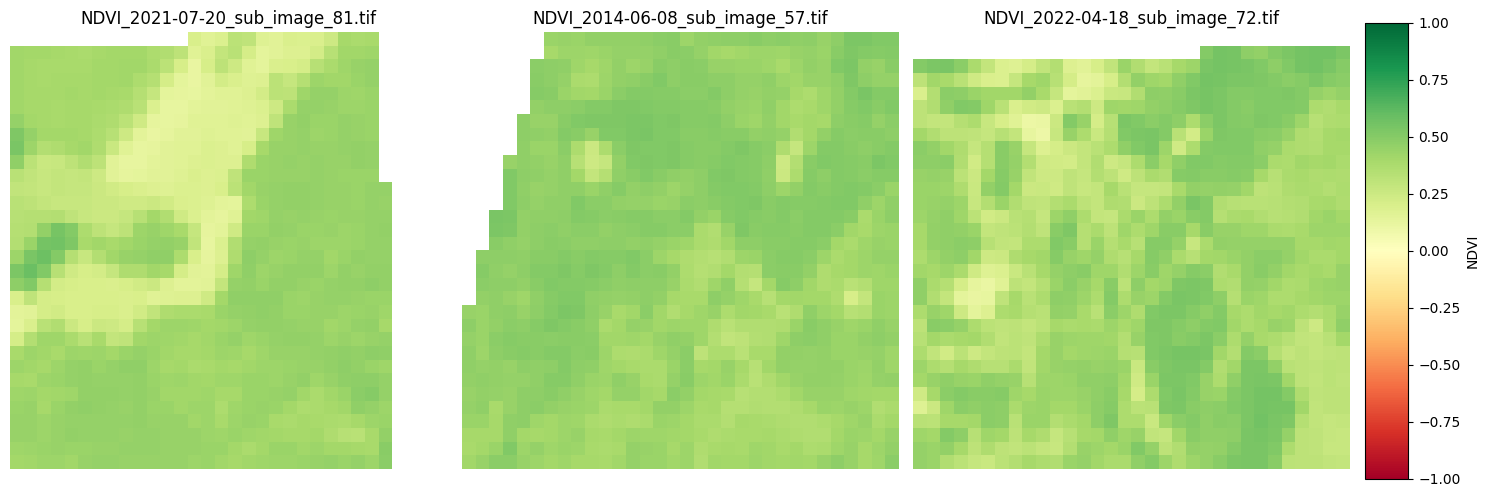

In [34]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_with_holes_dir) if f.endswith('.tif')]

# Specify the indices of images you want to display
selected_indices = [0, 5, 500 ]

# Safeguard: Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up a GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
#Batching
batch_size = 32

train = train_dir.batch()
train_holes = train_with_holes_dir.batch()